# Assignment 7: Multi-Armed Bandits
## A7.1. Modifying the Bandits Problem and the ε-Greedy Solver

In [10]:
import time
import random
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, Layout, Button, Box
import ipywidgets as widgets

## Defining a Bandit

In [11]:
class Bandit():
    def __init__(self, n, thetas, rewards):
        assert n == len(thetas)
        self.n = n # Number of arms
        self.thetas = thetas # Reward probabilities
        self.best_theta = max(self.thetas) # Reward probability of best arm
        self.rewards = rewards # Reward for each arm
    
    def pull_arm(self, i):
        # Function to pull an arm i and return a reward (0 or 1) with probability theta for i
        return self.rewards[i] if np.random.random() < self.thetas[i] else 0
        

## Defining a Generic Solver

In [12]:
class Solver():
    def __init__(self, bandit):
        np.random.seed(int(time.time()))
        # bandit(Bandit): the target bandit to solve
        assert isinstance (bandit, Bandit)
        self.bandit = bandit
        self.counts = [0] * bandit.n # Number of times each arm pulled
        self.actions = [] # Action history
        self.regret = 0. # Cumulative regret
        self.regrets = [0.] # History of regrets
    
    def update_regret(self, i):
        # Update cumulative regret and regret history when arm i is pulled
        self.regret += self.bandit.best_theta - self.bandit.thetas[i]
        self.regrets.append(self.regret)
        
    @property
    def estimated_thetas(self):
        raise NotImplementedError
    
    # Generic function that performs one step, and returns index of arm pulled    
    def run_one_step(self):
        raise NotImplementedError
        
    # Conduct one trial with given number of iterations (steps)       
    def run(self, num_steps):
        assert self.bandit is not None
        for _ in range(num_steps):
            i = self.run_one_step()
            self.counts[i] += 1
            self.actions.append(i)
            self.update_regret(i)   
            

## Defining an Experiment

In [13]:
def run_solver(solver, trials = 20, iterations = 10000, print_log = True):
    cumulative_regrets = [] # Cumulative regret for all 20 trials
    for trial in range(trials):
        solver.regret = 0.
        solver.regrets = [0.]
        solver.run(iterations)
        cumulative_regrets.append(solver.regret)
    if print_log:
        print(f'Solver: {solver.name}\nCumulative regret (mean): {np.mean(cumulative_regrets)}; Cumulative regret (std): {np.std(cumulative_regrets)}')
        action_count = [solver.actions.count(arm)/trials for arm in range(bandit.n)]
        print(f"Actions per arm: {action_count}")
    

## 7.1 Modifying the Bandits Problem and the ε-Greedy Solver 
### 7.1.1 Update the Bandit

### 1. Explore-Only

In [14]:
class Random(Solver):
    def __init__(self, bandit):
        super(Random, self).__init__(bandit)
        self.name = "Random"
        
        
    def run_one_step(self):
        i = np.random.randint(0, self.bandit.n) # Select random arm
        reward = self.bandit.pull_arm(i)
        return i

####  1.1 Reward  Effects

In [15]:
reward_lists = [
    [0.01, 1, 40],
    [50, 3, 0.02],
    [0.06, 400, 10],
    [10, 0.1, 100],
    [30, 0.01, 80]
]
for i in range(5):
    print('===========')
    rewards = reward_lists[i]
    reward_probs = [0.3, 0.4, 0.5]
    print('rewards: ', rewards)
    print('reward_probs: ', reward_probs)
    bandit = Bandit(3, reward_probs, rewards)
    random_solver = Random(bandit)
    run_solver(random_solver)

rewards:  [0.01, 1, 40]
reward_probs:  [0.3, 0.4, 0.5]
Solver: Random
Cumulative regret (mean): 999.4200000001131; Cumulative regret (std): 6.617219960075439
Actions per arm: [3325.75, 3342.7, 3331.55]
rewards:  [50, 3, 0.02]
reward_probs:  [0.3, 0.4, 0.5]
Solver: Random
Cumulative regret (mean): 1000.0500000001135; Cumulative regret (std): 8.445856972506057
Actions per arm: [3327.4, 3345.7, 3326.9]
rewards:  [0.06, 400, 10]
reward_probs:  [0.3, 0.4, 0.5]
Solver: Random
Cumulative regret (mean): 999.9200000001132; Cumulative regret (std): 8.71180807869577
Actions per arm: [3324.6, 3350.0, 3325.4]
rewards:  [10, 0.1, 100]
reward_probs:  [0.3, 0.4, 0.5]
Solver: Random
Cumulative regret (mean): 1001.0850000001132; Cumulative regret (std): 7.4156776494145085
Actions per arm: [3347.95, 3314.95, 3337.1]
rewards:  [30, 0.01, 80]
reward_probs:  [0.3, 0.4, 0.5]
Solver: Random
Cumulative regret (mean): 998.5050000001127; Cumulative regret (std): 8.273601090216504
Actions per arm: [3330.5, 3324.0

#### 1.2 Discussion

From the result, I can see that the 'Cumulative regret' and the 'Actions per arm' didn't change. So different rewards won't influence the selection of bandits. Also, from the definition of regret, it relates reward probability only. It also chooses action randomly each time. As a result, setting different rewards won't influence the final solution.

### 2. Exploit-Only

In [16]:
class Greedy(Solver):
    def __init__(self, bandit, arm):
        super(Greedy, self).__init__(bandit)
        self.name = "Greedy"
        self.arm = arm
    
    def run_one_step(self):
        reward = self.bandit.pull_arm(self.arm)
        return self.arm
    

#### 2.1 Reward  Effects

In [17]:
# Reward Effects
reward_lists = [
    [0.01, 1, 40],
    [50, 3, 0.02],
    [0.06, 400, 10],
    [10, 0.1, 100],
    [30, 0.01, 800]
]
for i in range(5):
    print('===========')
    rewards = reward_lists[i]
    reward_probs = [0.3, 0.4, 0.5]
    print('rewards: ', rewards)
    print('reward_probs: ', reward_probs)
    bandit = Bandit(3, reward_probs, rewards)
    random_solver = Greedy(bandit, random.choice(range(bandit.n)))
    run_solver(random_solver)

rewards:  [0.01, 1, 40]
reward_probs:  [0.3, 0.4, 0.5]
Solver: Greedy
Cumulative regret (mean): 2000.0000000003179; Cumulative regret (std): 2.2737367544323206e-13
Actions per arm: [10000.0, 0.0, 0.0]
rewards:  [50, 3, 0.02]
reward_probs:  [0.3, 0.4, 0.5]
Solver: Greedy
Cumulative regret (mean): 0.0; Cumulative regret (std): 0.0
Actions per arm: [0.0, 0.0, 10000.0]
rewards:  [0.06, 400, 10]
reward_probs:  [0.3, 0.4, 0.5]
Solver: Greedy
Cumulative regret (mean): 2000.0000000003179; Cumulative regret (std): 2.2737367544323206e-13
Actions per arm: [10000.0, 0.0, 0.0]
rewards:  [10, 0.1, 100]
reward_probs:  [0.3, 0.4, 0.5]
Solver: Greedy
Cumulative regret (mean): 1000.0000000001589; Cumulative regret (std): 1.1368683772161603e-13
Actions per arm: [0.0, 10000.0, 0.0]
rewards:  [30, 0.01, 800]
reward_probs:  [0.3, 0.4, 0.5]
Solver: Greedy
Cumulative regret (mean): 2000.0000000003179; Cumulative regret (std): 2.2737367544323206e-13
Actions per arm: [10000.0, 0.0, 0.0]


#### 2.2 Discussion
We can find that the results still are not influenced by different rewards. When one arm is selected firstly, it will be selected forever. The regret cumulative is related to the selection of arm, if the probability of the selected arm is the highest, the cumulative regret will be 0, otherwise, it will increase.

### 3. $\epsilon$-Greedy:

In [18]:
class EpsilonGreedy(Solver):
    def __init__(self, bandit, epsilon, init_theta = 1.0):
        super(EpsilonGreedy, self).__init__(bandit)
        self.name = "EpsilonGreedy"
        assert 0 <= epsilon <= 1
        self.epsilon = epsilon
        self.estimates = [init_theta] * self.bandit.n 
    
    def estimated_thetas(self):
        # Get theta estimates for all arms
        return self.estimates
    
    def run_one_step(self):
        # First, we need to decide whether to explore or exploit (based on epsilon)
        if np.random.random() < self.epsilon:
            # Explore by picking random arm when value less than epsilon
            arm = random.choice(range(self.bandit.n))
        else:
            # Exploit by selecting the best arm so far
            arm = max(range(self.bandit.n), key = lambda x: self.estimates[x])
            
        # Now, we pull the arm and get a reward, and then update theta estimate for the arm
        reward = self.bandit.pull_arm(arm)
        self.estimates[arm] += 1. / (self.counts[arm]+1) * (reward - self.estimates[arm])
        return arm
        

#### 3.1 Reward Effect

In [19]:
# Reward Effects
reward_lists = [
    [0.01, 1, 40],
    [50, 3, 0.02],
    [0.06, 400, 10],
    [10, 0.1, 100],
    [30, 0.01, 800]
]
for i in range(5):
    print('===========')
    rewards = reward_lists[i]
    reward_probs = [0.3, 0.4, 0.5]
    print('rewards: ', rewards)
    print('reward_probs: ', reward_probs)
    bandit = Bandit(3, reward_probs, rewards)
    epsilon_greedy_solver = EpsilonGreedy(bandit, 0.1) # epsilon = 0.1 => explore 10% and exploit 90%
    run_solver(epsilon_greedy_solver)

rewards:  [0.01, 1, 40]
reward_probs:  [0.3, 0.4, 0.5]
Solver: EpsilonGreedy
Cumulative regret (mean): 100.36000000000014; Cumulative regret (std): 4.358256532146786
Actions per arm: [334.75, 334.1, 9331.15]
rewards:  [50, 3, 0.02]
reward_probs:  [0.3, 0.4, 0.5]
Solver: EpsilonGreedy
Cumulative regret (mean): 1899.580000000279; Cumulative regret (std): 3.2114794098683714
Actions per arm: [9330.8, 334.2, 335.0]
rewards:  [0.06, 400, 10]
reward_probs:  [0.3, 0.4, 0.5]
Solver: EpsilonGreedy
Cumulative regret (mean): 1000.3850000001545; Cumulative regret (std): 3.0841976266126583
Actions per arm: [334.05, 9335.75, 330.2]
rewards:  [10, 0.1, 100]
reward_probs:  [0.3, 0.4, 0.5]
Solver: EpsilonGreedy
Cumulative regret (mean): 101.97500000000012; Cumulative regret (std): 4.301496832499124
Actions per arm: [343.4, 332.95, 9323.65]
rewards:  [30, 0.01, 800]
reward_probs:  [0.3, 0.4, 0.5]
Solver: EpsilonGreedy
Cumulative regret (mean): 101.08500000000008; Cumulative regret (std): 3.21174018251784

#### 3.2 Discussion
This solver is related to rewards. When the reward of one arm is much more larger than other arms, although the reward probability of the arm is lower, it can be selected more times. As a result, the reward and reward probability jointly influence the results. The greater their multiplicative value, the greater the effect on the result.

### 4. UCB1 

In [20]:
class UCB1(Solver):
    def __init__(self, bandit, init_theta = 1.0):
        # Initial thetas optimistically set to 1.0
        super(UCB1, self).__init__(bandit)
        self.t = 0 # Timestep
        self.estimates = [init_theta]*self.bandit.n
        self.name = "UCB1"
        
    @property
    def estimated_thetas(self):
        return self.estimates
    
    def run_one_step(self):
        self.t += 1
        
        #Pick the best arm using UCB, pull and get reward
        arm = max(range(self.bandit.n),
                  key = lambda x: self.estimates[x] + np.sqrt(2*np.log(self.t)/(1+self.counts[x])))
        reward = self.bandit.pull_arm(arm)
        #Update theta estimate for arm
        self.estimates[arm] += 1./(self.counts[arm]+1) * (reward - self.estimates[arm])
        
        return arm

#### 4.1 Reward Effect

In [21]:
# Reward Effects
reward_lists = [
    [2, 3, 1000],
    [1, 100, 1000],
    [40, 40, 40],
    [1, 999, 1000],
    [50, 60, 70]
]

for i in range(5):
    print('===========')
    rewards = reward_lists[i]
    reward_probs = [0.3, 0.4, 0.5]
    print('rewards: ', rewards)
    print('reward_probs: ', reward_probs)
    bandit = Bandit(3, reward_probs, rewards)
    ucb_solver = UCB1(bandit)
    run_solver(ucb_solver)

rewards:  [2, 3, 1000]
reward_probs:  [0.3, 0.4, 0.5]
Solver: UCB1
Cumulative regret (mean): 0.11499999999999999; Cumulative regret (std): 0.5012733785071775
Actions per arm: [0.4, 0.35, 9999.25]
rewards:  [1, 100, 1000]
reward_probs:  [0.3, 0.4, 0.5]
Solver: UCB1
Cumulative regret (mean): 0.015; Cumulative regret (std): 0.0653834841531101
Actions per arm: [0.05, 0.05, 9999.9]
rewards:  [40, 40, 40]
reward_probs:  [0.3, 0.4, 0.5]
Solver: UCB1
Cumulative regret (mean): 1000.005000000159; Cumulative regret (std): 0.02179449471770832
Actions per arm: [0.05, 9999.95, 0.0]
rewards:  [1, 999, 1000]
reward_probs:  [0.3, 0.4, 0.5]
Solver: UCB1
Cumulative regret (mean): 0.015; Cumulative regret (std): 0.0653834841531101
Actions per arm: [0.05, 0.05, 9999.9]
rewards:  [50, 60, 70]
reward_probs:  [0.3, 0.4, 0.5]
Solver: UCB1
Cumulative regret (mean): 2000.0000000003179; Cumulative regret (std): 2.2737367544323206e-13
Actions per arm: [10000.0, 0.0, 0.0]


#### 4.2 Discussion
From the result, it's hard to judge how the rewards influence the final solusion. If the optinal arm has much larger reward than another two arms, it's most likely to be selected each time. But if the reward difference is not obvious or not large enough, the uncertainty of arms is increasing, so that another two arms can also be selected multiple times. At the same time, the cumulative regret will increase dramatically. According to this solver, in addition to those which set large disparity rewards, all options will be selected many times for experiment. Different rewards will make the selection more complicated.  

In [22]:
class ThomsonSampling(Solver):
    def __init__(self, bandit, init_alpha=1, init_beta=1):
        """
        init_alpha (int): initial value of alpha in Beta(alpha, beta).
        init_beta (int): initial value of beta in Beta(alpha, beta).
        """
        super(ThomsonSampling, self).__init__(bandit)
        self._alphas = [init_alpha]*self.bandit.n
        self._betas = [init_beta]*self.bandit.n
        self.name = "Thomson Sampling"
        
    @property
    def estimated_thetas(self):
        return [self._alphas[i]/(self._alphas[i] + self._betas[i]) for i in range(self.bandit.n)]
    
    def run_one_step(self):
        # Get sample for each arm from beta distribution 
        samples = [np.random.beta(self._alphas[i], self._betas[i]) for i in range(self.bandit.n)]
        
        # Select best arm and get reward by pulling it
        arm = max(range(self.bandit.n), key=lambda x: samples[x]) # Get arm with highest sample value
        reward = self.bandit.pull_arm(arm)
        
        # Update alpha and beta for arm
#         self._alphas[arm] += reward # Increment alpha by 1 if reward received
#         self._betas[arm] += (1 - reward) # Increment beta by 1 if no reward received
        if reward:
            self._alphas[arm] += 1
        else:
            self._betas[arm] += 1
        
        return arm

#### 5.1 Reward Effects

In [23]:
# Reward Effects
reward_lists = [
    [2, 3, 1000],
    [1, 100, 1000],
    [40, 40, 40],
    [1, 999, 1000],
    [50, 60, 70]
]

for i in range(5):
    print('===========')
    rewards = reward_lists[i]
    reward_probs = [0.3, 0.4, 0.5]
    print('rewards: ', rewards)
    print('reward_probs: ', reward_probs)
    bandit = Bandit(3, reward_probs, rewards)
    thomson_solver = ThomsonSampling(bandit)
    run_solver(thomson_solver)

rewards:  [2, 3, 1000]
reward_probs:  [0.3, 0.4, 0.5]
Solver: Thomson Sampling
Cumulative regret (mean): 2.995000000000002; Cumulative regret (std): 6.606245151370037
Actions per arm: [4.8, 20.35, 9974.85]
rewards:  [1, 100, 1000]
reward_probs:  [0.3, 0.4, 0.5]
Solver: Thomson Sampling
Cumulative regret (mean): 2.1700000000000035; Cumulative regret (std): 6.542484237657754
Actions per arm: [4.6, 12.5, 9982.9]
rewards:  [40, 40, 40]
reward_probs:  [0.3, 0.4, 0.5]
Solver: Thomson Sampling
Cumulative regret (mean): 2.2449999999999983; Cumulative regret (std): 5.052373204742491
Actions per arm: [6.55, 9.35, 9984.1]
rewards:  [1, 999, 1000]
reward_probs:  [0.3, 0.4, 0.5]
Solver: Thomson Sampling
Cumulative regret (mean): 1.565000000000002; Cumulative regret (std): 4.87814257684214
Actions per arm: [3.55, 8.55, 9987.9]
rewards:  [50, 60, 70]
reward_probs:  [0.3, 0.4, 0.5]
Solver: Thomson Sampling
Cumulative regret (mean): 6.934999999999825; Cumulative regret (std): 30.228964173453804
Actions

#### 5.2 Discussion
From this result, we can see this solver is more stable. The optimal arm can be selected in most times and the cumulative regret is quite low. The regret won't influence the result, because when getting reward, the alpha adds 1, otherwise the beta adds 1 (I modified the code). Thus the concret number of reward doesn't make any difference.

## Compare the solvers

We now compare the solvers by running the experiment and printing the mean cumulative regret and standard deviation.

rewards:  [0.01, 1, 40]
reward_probs:  [0.3, 0.4, 0.5]


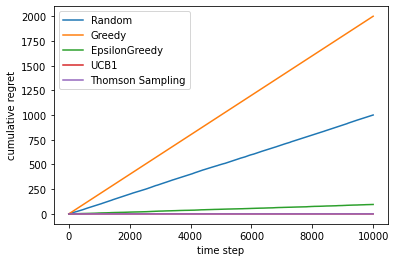

rewards:  [50, 3, 0.02]
reward_probs:  [0.3, 0.4, 0.5]


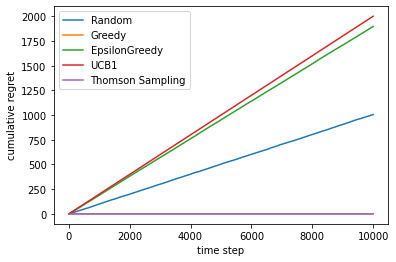

rewards:  [0.06, 400, 10]
reward_probs:  [0.3, 0.4, 0.5]


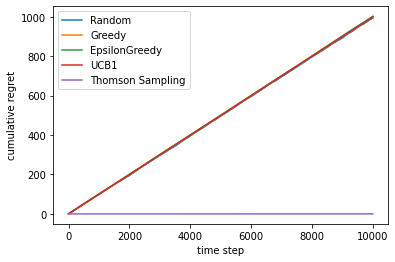

rewards:  [10, 0.1, 100]
reward_probs:  [0.3, 0.4, 0.5]


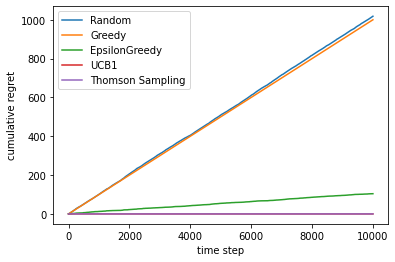

rewards:  [30, 0.01, 80]
reward_probs:  [0.3, 0.4, 0.5]


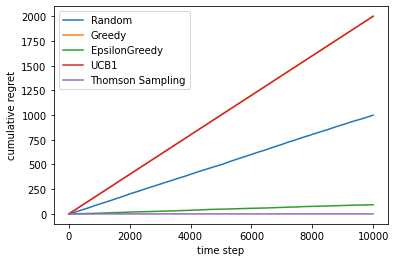

In [24]:
def compare_solvers(bandit):
    random_solver = Random(bandit)
    greedy_solver = Greedy(bandit, random.choice(range(bandit.n)))
    epsilon_greedy_solver = EpsilonGreedy(bandit, 0.1)
    ucb_solver = UCB1(bandit)
    thomson_solver = ThomsonSampling(bandit)
    for solver in [random_solver, greedy_solver, epsilon_greedy_solver, ucb_solver, thomson_solver]:
        run_solver(solver, print_log=False)
        plt.plot(solver.regrets, label = solver.name)

    plt.legend()
    plt.xlabel('time step')
    plt.ylabel('cumulative regret')
    plt.show()
    

    
# Reward Effects
reward_lists = [
    [0.01, 1, 40],
    [50, 3, 0.02],
    [0.06, 400, 10],
    [10, 0.1, 100],
    [30, 0.01, 80]
]

for i in range(5):
    print('===========')
    rewards = reward_lists[i]
    reward_probs = [0.3, 0.4, 0.5]
    print('rewards: ', rewards)
    print('reward_probs: ', reward_probs)
    bandit = Bandit(3, reward_probs, rewards)
    compare_solvers(bandit)

### Summarize

In conclusion, the Thompson Solver has the best performance. And the Thompson Solver, the Random and Greedy solver are almost unaffected by the reward. The UCB1 and EpsilonGreedy solver are influenced much. The UCB1 and the EpsilonGreedy solver have better performance when the optimal arm has far larger reward than another two arms.

### Bonus:  Sample the reward from a distribution

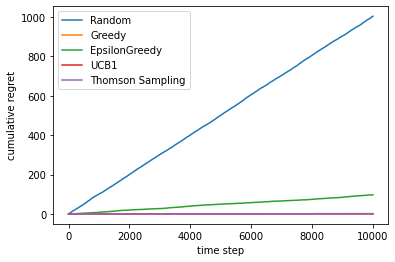

In [25]:
class Bandit():
    def __init__(self, n, thetas):
        assert n == len(thetas)
        self.n = n # Number of arms
        self.thetas = thetas # Reward probabilities
        self.best_theta = max(self.thetas) # Reward probability of best arm
    
    def pull_arm(self, i):
        mu, sigma = 1, 0.5 # mean and standard deviation
        reward = abs(np.random.normal(mu, sigma, 1)[0]) # Gaussion distribution
        return reward if np.random.random() < self.thetas[i] else 0
        
bandit = Bandit(3, [0.3,0.4,0.5])

compare_solvers(bandit)

When the reward obeys the Gaussion distribution, the result shows that the EpsilonGreedy, UCB1 and Thomson Sampling have good performance. The Random and the Greedy have more cumulative regret.

### 7.1.2  Create a variation of the ε-Greedy Solver

#### Improvement Strategy

If one arm is selected much more times, we could think that this arm may be the optimal choice, in this case, we could reduce the explore freqency gradualy.

I set `max_count` to record the counts of every arm selected. If one arm is selected over 600 times, the epsilon will reduce by 0.01 each time.

As a result, we could see that the number of exploration will reduce finally.

In [66]:
class Bandit():
    def __init__(self, n, thetas):
        assert n == len(thetas)
        self.n = n # Number of arms
        self.thetas = thetas # Reward probabilities
        self.best_theta = max(self.thetas) # Reward probability of best arm
    
    def pull_arm(self, i):
        # Function to pull an arm i and return a reward (0 or 1) with probability theta for i
        return 1 if np.random.random() < self.thetas[i] else 0

class EpsilonGreedy(Solver):
    def __init__(self, bandit, epsilon, init_theta = 1.0, change_epsilon = False):
        super(EpsilonGreedy, self).__init__(bandit)
        self.name = "EpsilonGreedy"
        assert 0 <= epsilon <= 1
        self.epsilon = epsilon
        self.estimates = [init_theta] * self.bandit.n
        self.change_epsilon = change_epsilon
        self.max_count = [0] * self.bandit.n
        self.strategy_type = [0, 0]
    
    def estimated_thetas(self):
        # Get theta estimates for all arms
        return self.estimates
    
    def run_one_step(self):
        # First, we need to decide whether to explore or exploit (based on epsilon)
        max_count_arm = np.max(self.max_count)
        if max_count_arm > 1000 and self.change_epsilon:
            self.epsilon += -0.01
        
        if np.random.random() < self.epsilon:
            # Explore by picking random arm when value less than epsilon
            arm = random.choice(range(self.bandit.n))
            self.strategy_type[0] += 1
        else:
            # Exploit by selecting the best arm so far
            arm = max(range(self.bandit.n), key = lambda x: self.estimates[x])
            self.strategy_type[1] += 1
            
        # Now, we pull the arm and get a reward, and then update theta estimate for the arm
        reward = self.bandit.pull_arm(arm)
        self.estimates[arm] += 1. / (self.counts[arm]+1) * (reward - self.estimates[arm])
        
        max_index = np.argmax(self.estimates)
        self.max_count[max_index] += 1
        
        return arm

In [67]:
bandit = bandit = Bandit(3, [0.3,0.4,0.5])
epsilon_greedy_solver = EpsilonGreedy(bandit, 0.1) # epsilon = 0.1 => explore 10% and exploit 90%
run_solver(epsilon_greedy_solver)
max_count = epsilon_greedy_solver.max_count
strategy_type_count = epsilon_greedy_solver.strategy_type
print('mean of max counts:', [x/20 for x in max_count])
print('mean of strategy selection counts:', [x/20 for x in strategy_type_count])

print('====== reduce epsilon gradually')
bandit = bandit = Bandit(3, [0.3,0.4,0.5])
epsilon_greedy_solver = EpsilonGreedy(bandit, 0.1, change_epsilon = True) # epsilon = 0.1 => explore 10% and exploit 90%
run_solver(epsilon_greedy_solver)
max_count = epsilon_greedy_solver.max_count
strategy_type_count = epsilon_greedy_solver.strategy_type
print('mean of max counts:', [x/20 for x in max_count])
print('mean of strategy selection counts:', [x/20 for x in strategy_type_count])

Solver: EpsilonGreedy
Cumulative regret (mean): 101.8200000000001; Cumulative regret (std): 6.677843963436041
Actions per arm: [341.85, 334.5, 9323.65]
mean of max counts: [6.75, 1.2, 9992.05]
mean of strategy selection counts: [999.55, 9000.45]
====== reduce epsilon gradually
Solver: EpsilonGreedy
Cumulative regret (mean): 0.49999999999999956; Cumulative regret (std): 2.1794494717703348
Actions per arm: [1.7, 1.6, 9996.7]
mean of max counts: [0.1, 0.05, 9999.85]
mean of strategy selection counts: [4.0, 9996.0]


The result shows that the solution is still the optimal one, but the exploration frequency reduces.

## A7.2 Design and Run an Online Experiment

In my design project, I assume that we hope users to click the target button which may lead them to another page or another feature of our website. The problem is that we want to know which layouts will attract them to notice the button and want to click it. To simplify this project, I put four buttons together, they are 'Like it', 'Ordinary', 'Not bad', 'Bad'. Each time, the system will display different layouts. If users click the button 'Like it' in one layout, we could say that this layout attracts them more. 

In [3]:
styles = ['flex-start', 'flex-end', 'center', 'space-between', 'space-around'] #Different layouts
class DesignDisplay():
    def __init__(self, n):
        self.n = n # Number of layout design
    
    def display_design(self, i, b_callback):
        items_layout = Layout( width='auto')

        box_layout = Layout(display='flex',
                            flex_flow='row',
                            align_items='center',
                            justify_content=styles[i],
                            border='solid',
                            width='50%')

        words = ['Like it', 'Ordinary', 'Not bad', 'Bad']
        items = []
        for word in words:
            button = Button(
                disabled=False,
                description=word,
                layout=items_layout,
                button_style='danger'
            )
            button.on_click(b_callback) # b_callback will listen for button click events
            items.append(button)

        box = Box(children=items, layout=box_layout)
        # show the box
        display(box)
        return box

In [4]:
design = DesignDisplay(5)

I choose the UCB1 solver to discover the optimal layout option.

In [5]:
class UCB1Solver():
    def __init__(self, design, init_theta = 1.0):
        np.random.seed(int(time.time()))
        assert isinstance (design, DesignDisplay)
        self.design = design
        self.counts = [0] * design.n # Number of times each design displayed
        self.actions = [] # Action history
        self.t = 0 # Timestep
        self.estimates = [init_theta]*self.design.n
        self.name = "UCB1"
        self.current_design = 0
    
    # Deal with the click events
    def button_callback(self, target):
        print('user clicked: ', target.description)
        if target.description == 'Like it': # return 1 when click the target, otherwise 0
            reward = 1
        else:
            reward = 0
        #Update theta estimate for design
        design_index = self.current_design
        self.estimates[design_index] += 1./(self.counts[design_index]+1) * (reward - self.estimates[design_index])
        
    @property
    def estimated_thetas(self):
        return self.estimates
    
    # Generic function that performs one step, and returns index of arm pulled    
    def run_one_step(self):
        self.t += 1
        
        #Pick the best design using UCB, display and get reward
        design = max(range(self.design.n),
                  key = lambda x: self.estimates[x] + np.sqrt(2*np.log(self.t)/(1+self.counts[x])))
        self.current_design = design
        box = self.design.display_design(design, self.button_callback)

        return design
        
    # Conduct one trial with given number of iterations (steps)       
    def run(self, num_steps):
        assert self.design is not None

        for _ in range(num_steps):
            i = self.run_one_step()
            self.counts[i] += 1
            self.actions.append(i)

In [6]:
ucb_solver = UCB1Solver(design)

In [7]:
def run_solver(solver):
    ucb_solver.run(1)

I'm going to click any of those buttons to simulate users' interaction. But to see when the solver will find the layout that users prefer, I will only click 'Like it' in the first layout, and click other buttons in other layouts. 

(Problem: I didn't find how to put the 'Toggle Design' button on the bottom. So it is a little inconvenient to click it when there are a large of layout sequences.)

In [8]:
run_button = widgets.Button(description="Toggle Design!")
run_button.on_click(run_solver)
display(run_button)

Button(description='Toggle Design!', style=ButtonStyle())

Box(children=(Button(button_style='danger', description='Like it', layout=Layout(width='auto'), style=ButtonSt…

user clicked:  Like it


Box(children=(Button(button_style='danger', description='Like it', layout=Layout(width='auto'), style=ButtonSt…

user clicked:  Ordinary


Box(children=(Button(button_style='danger', description='Like it', layout=Layout(width='auto'), style=ButtonSt…

user clicked:  Not bad


Box(children=(Button(button_style='danger', description='Like it', layout=Layout(width='auto'), style=ButtonSt…

user clicked:  Bad


Box(children=(Button(button_style='danger', description='Like it', layout=Layout(width='auto'), style=ButtonSt…

user clicked:  Not bad


Box(children=(Button(button_style='danger', description='Like it', layout=Layout(width='auto'), style=ButtonSt…

user clicked:  Like it


Box(children=(Button(button_style='danger', description='Like it', layout=Layout(width='auto'), style=ButtonSt…

user clicked:  Like it


Box(children=(Button(button_style='danger', description='Like it', layout=Layout(width='auto'), style=ButtonSt…

user clicked:  Like it


Box(children=(Button(button_style='danger', description='Like it', layout=Layout(width='auto'), style=ButtonSt…

user clicked:  Ordinary


Box(children=(Button(button_style='danger', description='Like it', layout=Layout(width='auto'), style=ButtonSt…

user clicked:  Ordinary


Box(children=(Button(button_style='danger', description='Like it', layout=Layout(width='auto'), style=ButtonSt…

user clicked:  Not bad


Box(children=(Button(button_style='danger', description='Like it', layout=Layout(width='auto'), style=ButtonSt…

user clicked:  Not bad


Box(children=(Button(button_style='danger', description='Like it', layout=Layout(width='auto'), style=ButtonSt…

user clicked:  Like it


Box(children=(Button(button_style='danger', description='Like it', layout=Layout(width='auto'), style=ButtonSt…

user clicked:  Like it


Box(children=(Button(button_style='danger', description='Like it', layout=Layout(width='auto'), style=ButtonSt…

user clicked:  Like it


Box(children=(Button(button_style='danger', description='Like it', layout=Layout(width='auto'), style=ButtonSt…

user clicked:  Like it


Box(children=(Button(button_style='danger', description='Like it', layout=Layout(width='auto'), style=ButtonSt…

user clicked:  Like it


Box(children=(Button(button_style='danger', description='Like it', layout=Layout(width='auto'), style=ButtonSt…

user clicked:  Like it


Box(children=(Button(button_style='danger', description='Like it', layout=Layout(width='auto'), style=ButtonSt…

user clicked:  Ordinary


Box(children=(Button(button_style='danger', description='Like it', layout=Layout(width='auto'), style=ButtonSt…

user clicked:  Not bad


Box(children=(Button(button_style='danger', description='Like it', layout=Layout(width='auto'), style=ButtonSt…

user clicked:  Bad


Box(children=(Button(button_style='danger', description='Like it', layout=Layout(width='auto'), style=ButtonSt…

user clicked:  Ordinary


Box(children=(Button(button_style='danger', description='Like it', layout=Layout(width='auto'), style=ButtonSt…

user clicked:  Like it


Box(children=(Button(button_style='danger', description='Like it', layout=Layout(width='auto'), style=ButtonSt…

user clicked:  Like it


Box(children=(Button(button_style='danger', description='Like it', layout=Layout(width='auto'), style=ButtonSt…

user clicked:  Like it


Box(children=(Button(button_style='danger', description='Like it', layout=Layout(width='auto'), style=ButtonSt…

user clicked:  Like it


Box(children=(Button(button_style='danger', description='Like it', layout=Layout(width='auto'), style=ButtonSt…

user clicked:  Like it


Box(children=(Button(button_style='danger', description='Like it', layout=Layout(width='auto'), style=ButtonSt…

user clicked:  Like it


Box(children=(Button(button_style='danger', description='Like it', layout=Layout(width='auto'), style=ButtonSt…

user clicked:  Like it


Box(children=(Button(button_style='danger', description='Like it', layout=Layout(width='auto'), style=ButtonSt…

user clicked:  Like it


Box(children=(Button(button_style='danger', description='Like it', layout=Layout(width='auto'), style=ButtonSt…

user clicked:  Like it


Box(children=(Button(button_style='danger', description='Like it', layout=Layout(width='auto'), style=ButtonSt…

In [9]:
action_count = [ucb_solver.actions.count(design) for design in range(design.n)]
print(f"Actions per design: {action_count}")

Actions per design: [20, 3, 3, 3, 3]


Discussion:  

The layouts are displayed in the following order:

1. five layouts appear in sequence
2. the first layout appears three times
3. another four layouts appear one time separately
4. the first layout appears six times
5. another four layouts appear one time separately
6. the first layout appears ten times.

The result represents that when users show obvious preferences, the UCB1 algorithm does a good job to catch users' decision and gives feedback to the system.